# Finetune

In this notebook, we will finetune on full resolution images

In [1]:
import os
import time

import numpy as np
import cv2

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from dataloader import CityScapesDataset
from transformations import *

In [10]:
BATCH_SIZE = 1
EPOCHS = 25
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
root = "C:/Users/itber/Documents/datasets/cityscapes"
OG_W, OG_H = 2048, 800 # OG width and height after crop
W, H = OG_W//2, OG_H//2 # resize w,h for training

train_transform = transforms.Compose([
    ToTensor(),
    # RandomCrop(H, W),
    AddColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    RandomHorizontalFlip(0.5),
    RandomVerticalFlip(0.2),
    Normalize()
])

valid_transform = transforms.Compose([
    ToTensor(),
    # Rescale(H, W),
    Normalize()
])


test_transform = transforms.Compose([
    ToTensor(),
    Normalize()
])

In [12]:
from dataloader import CityScapesDataset

train_dataset = CityScapesDataset(root, transform=train_transform, split='train', label_map='trainId')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)

valid_dataset = CityScapesDataset(root, transform=valid_transform, split='val', label_map='trainId')
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)

test_dataset = CityScapesDataset(root, transform=test_transform, split='test', label_map='trainId')
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)

NUM_SEG_CLASSES = len(test_dataset.trainid_2_name)
NUM_SEG_CLASSES

20

In [13]:
from labels import labels

def convert_to_numpy(image):
    if not isinstance(image, np.ndarray):
        if len(image.shape) == 2:
            image = image.detach().cpu().numpy()
        else:
            image = image.detach().cpu().numpy().transpose(1, 2, 0)

    return image

def get_color_mask(mask, labels, id_type='id'):
    try:
        h, w = mask.shape
    except ValueError:
        mask = mask.squeeze(-1)
        h, w = mask.shape

    color_mask = np.zeros((h, w, 3), dtype=np.uint8)

    if id_type == 'id':
        for lbl in labels:
            color_mask[mask == lbl.id] = lbl.color
    elif id_type == 'trainId':
        for lbl in labels:
            if (lbl.trainId != 255) | (lbl.trainId != -1):
                color_mask[mask == lbl.trainId] = lbl.color

    return color_mask


def plot_items(left, mask, depth, labels=None, num_seg_labels=34, id_type='id'):
    left = convert_to_numpy(left)
    mask = convert_to_numpy(mask)
    depth = convert_to_numpy(depth)

    # unnormalize left image
    left = (left*np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])

    # cmaps: 'prism', 'terrain', 'turbo', 'gist_rainbow_r', 'nipy_spectral_r'
    
    
    _, ax = plt.subplots(1, 3, figsize=(15,10))
    ax[0].imshow(left)
    ax[0].set_title("Left Image")

    if labels:
        color_mask = get_color_mask(mask, labels, id_type)
        ax[1].imshow(color_mask)
    else:
        cmap = mpl.colormaps.get_cmap('nipy_spectral_r').resampled(num_seg_labels)
        ax[1].imshow(mask, cmap=cmap)

    ax[1].set_title("Seg Mask")
    ax[2].imshow(depth, cmap='plasma')
    ax[2].set_title("Depth")

### Get Model

In [14]:
from torchvision.models import mobilenet_v3_small
from model import MobileNetV3Backbone, LightWeightRefineNet, MultiTaskNetwork


mobilenet_backbone = mobilenet_v3_small(weights='IMAGENET1K_V1')

encoder = MobileNetV3Backbone(mobilenet_backbone.features)
decoder = LightWeightRefineNet(NUM_SEG_CLASSES)

# unfreeze all weights
model = MultiTaskNetwork(encoder, decoder, freeze_encoder=False).to(DEVICE)

In [15]:
# weights_path = r"C:\Users\itber\Documents\learning\self_tutorials\CV_projects\multitask_depth_seg\models\model_148.pth"
weights_path = r"C:\Users\itber\Documents\learning\self_tutorials\CV_projects\multitask_depth_seg\models\model_23_ft_half.pth" 
model.load_state_dict(torch.load(weights_path));

In [16]:
# ref: https://github.com/DrSleep/DenseTorch/blob/master/densetorch/engine/losses.py
class InvHuberLoss(nn.Module):
    """Inverse Huber Loss for depth estimation.

    The setup is taken from https://arxiv.org/abs/1606.00373

    Args:
      ignore_index (float): value to ignore in the target
                            when computing the loss.

    """

    def __init__(self, ignore_index=0):
        super(InvHuberLoss, self).__init__()
        self.ignore_index = ignore_index

    def forward(self, x, target):
        input = F.relu(x)  # depth predictions must be >=0
        diff = input - target
        mask = target != self.ignore_index

        err = torch.abs(diff * mask.float())
        c = 0.2 * torch.max(err)
        err2 = (diff ** 2 + c ** 2) / (2.0 * c)
        mask_err = err <= c
        mask_err2 = err > c
        cost = torch.mean(err * mask_err.float() + err2 * mask_err2.float())
        return cost

In [17]:
optimizer = optim.Adam(model.parameters(), lr=5e-6)
# loss functions
seg_criterion = nn.CrossEntropyLoss()
depth_criterion = nn.MSELoss()
# depth_criterion = InvHuberLoss()

In [18]:
from torchmetrics import JaccardIndex

jaccard = JaccardIndex(task='multiclass', threshold=0.5, num_classes=NUM_SEG_CLASSES) # usage: jaccard(pred, target)


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, window_size=None):
        self.length = 0
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.window_size = window_size

    def reset(self):
        self.length = 0
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        if self.window_size and (self.count >= self.window_size):
            self.reset()
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.round(self.sum / self.count, 4)

In [19]:
# find optimal backend for performning convolutions
torch.backends.cudnn.benchmark = True

In [21]:
model_root = r'C:\Users\itber\Documents\learning\self_tutorials\CV_projects\multitask_depth_seg\models'

model.to(DEVICE).train()

# scaling parameter for loss function
# c = 0.5

best_valid_loss = np.inf

avg_train_metrics = {
    'seg_losses' : [],
    'depth_losses' : [],
    'losses' : [],
    'iou' : []
}

avg_valid_metrics = {
    'seg_losses' : [],
    'depth_losses' : [],
    'losses' : [],
    'iou' : []
}


for e in range(EPOCHS):
    train_metrics = {
        'seg_losses' : AverageMeter(),
        'depth_losses' : AverageMeter(),
        'losses' : AverageMeter(),
        'iou' : AverageMeter()
    }

    model.train()

    for i, sample in enumerate(train_loader):
        left, mask, depth = sample['left'], sample['mask'].squeeze(1), sample['depth'].squeeze(1)
        left, mask, depth = left.to(DEVICE), mask.to(DEVICE), depth.to(DEVICE)

        # get predictions
        pred_seg, pred_depth = model(left)

        # reshape seg
        pred_seg = pred_seg.view(BATCH_SIZE, NUM_SEG_CLASSES, -1)
        mask = mask.view(BATCH_SIZE, -1).to(torch.long)
        
        # compute losses
        seg_loss = seg_criterion(pred_seg, mask)
        depth_loss = depth_criterion(pred_depth, depth)
        loss = seg_loss + depth_loss

        # zero gradients 
        optimizer.zero_grad()

        # back prop loss
        loss.backward()

        # step weights
        optimizer.step()

        # store metrics
        train_metrics['seg_losses'].update(seg_loss.item())
        train_metrics['depth_losses'].update(depth_loss.item())
        train_metrics['losses'].update(loss.item())
        train_metrics['iou'].update(jaccard(pred_seg.detach().cpu(), mask.detach().cpu()).numpy())

        if i % 250 == 0:
            print(f"train: epoch {e} - iteration: {i} - seg loss: {train_metrics['seg_losses'].avg}" + \
                  f" - depth loss: {train_metrics['depth_losses'].avg} - loss: {train_metrics['losses'].avg}" + \
                  f" - IOU: {train_metrics['iou'].avg}")
            
            # cooldown
            time.sleep(5)
    
    # save average metrics
    avg_train_metrics['seg_losses'].append(np.round(train_metrics['seg_losses'].avg, 3))
    avg_train_metrics['depth_losses'].append(np.round(train_metrics['depth_losses'].avg, 3))
    avg_train_metrics['losses'].append(np.round(train_metrics['losses'].avg, 3))
    avg_train_metrics['iou'].append(np.round(train_metrics['iou'].avg, 3))

    # display train metrics
    print(f"train epoch {e} - avg seg loss: {avg_train_metrics['seg_losses'][-1]}" + \
          f" - avg depth loss: {avg_train_metrics['depth_losses'][-1]} - avg loss: {avg_train_metrics['losses'][-1]}" + \
          f" - avg IOU: {avg_train_metrics['iou'][-1]}")

    # validate model
    valid_metrics = {
        'seg_losses' : AverageMeter(),
        'depth_losses' : AverageMeter(),
        'losses' : AverageMeter(),
        'iou' : AverageMeter()
    }

    model.eval()
    with torch.no_grad():
        for i, sample in enumerate(valid_loader):
            left, mask, depth = sample['left'], sample['mask'].squeeze(1), sample['depth'].squeeze(1)
            left, mask, depth = left.to(DEVICE), mask.to(DEVICE), depth.to(DEVICE)

            # get predictions
            pred_seg, pred_depth = model(left)

            # reshape seg
            pred_seg = pred_seg.view(BATCH_SIZE, NUM_SEG_CLASSES, -1)
            mask = mask.view(BATCH_SIZE, -1).to(torch.long)

            # compute losses
            seg_loss = seg_criterion(pred_seg, mask)
            depth_loss = depth_criterion(pred_depth, depth)
            loss = seg_loss + depth_loss

            # store metrics
            valid_metrics['seg_losses'].update(seg_loss.item())
            valid_metrics['depth_losses'].update(depth_loss.item())
            valid_metrics['losses'].update(loss.item())
            valid_metrics['iou'].update(jaccard(pred_seg.detach().cpu(), mask.detach().cpu()).numpy())

            if i % 250 == 0:
                print(f"valid: epoch {e} - iteration: {i} - seg loss: {valid_metrics['seg_losses'].avg}" + \
                    f" - depth loss: {valid_metrics['depth_losses'].avg} - loss: {valid_metrics['losses'].avg}" + \
                    f" - IOU: {valid_metrics['iou'].avg}")
                
                # cooldown
                # time.sleep(5)

        # save average metrics
        avg_valid_metrics['seg_losses'].append(np.round(valid_metrics['seg_losses'].avg, 3))
        avg_valid_metrics['depth_losses'].append(np.round(valid_metrics['depth_losses'].avg, 3))
        avg_valid_metrics['losses'].append(np.round(valid_metrics['losses'].avg, 3))
        avg_valid_metrics['iou'].append(np.round(valid_metrics['iou'].avg, 3))

        # display valid metrics
        print(f"valid: epoch {e} - avg seg loss: {avg_valid_metrics['seg_losses'][-1]}" + \
            f" - avg  depth loss: {avg_valid_metrics['depth_losses'][-1]} - avg loss: {avg_valid_metrics['losses'][-1]}" + \
            f" - avg IOU: {avg_valid_metrics['iou'][-1]}")

        # save best model based on overall loss
        if avg_valid_metrics['losses'][-1] <= best_valid_loss:
            best_valid_loss = avg_valid_metrics['losses'][-1]

            # save model
            model_savepath = os.path.join(model_root, f"model_{e}_ft_half.pth")

            torch.save(model.state_dict(), model_savepath) # save state dict

        # cooldown
        time.sleep(5)

train: epoch 0 - iteration: 0 - seg loss: 0.3778 - depth loss: 0.0069 - loss: 0.3847 - IOU: 0.3279
train: epoch 0 - iteration: 250 - seg loss: 0.5141 - depth loss: 0.0076 - loss: 0.5217 - IOU: 0.2874
train: epoch 0 - iteration: 500 - seg loss: 0.5169 - depth loss: 0.0077 - loss: 0.5246 - IOU: 0.2872
train: epoch 0 - iteration: 750 - seg loss: 0.5094 - depth loss: 0.0074 - loss: 0.5168 - IOU: 0.2879
train: epoch 0 - iteration: 1000 - seg loss: 0.5015 - depth loss: 0.0073 - loss: 0.5088 - IOU: 0.2895
train: epoch 0 - iteration: 1250 - seg loss: 0.4983 - depth loss: 0.0072 - loss: 0.5055 - IOU: 0.2914
train: epoch 0 - iteration: 1500 - seg loss: 0.4929 - depth loss: 0.0072 - loss: 0.5 - IOU: 0.292
train: epoch 0 - iteration: 1750 - seg loss: 0.4901 - depth loss: 0.0072 - loss: 0.4972 - IOU: 0.292
train: epoch 0 - iteration: 2000 - seg loss: 0.4874 - depth loss: 0.0071 - loss: 0.4945 - IOU: 0.2927
train: epoch 0 - iteration: 2250 - seg loss: 0.486 - depth loss: 0.007 - loss: 0.4931 - IOU: 

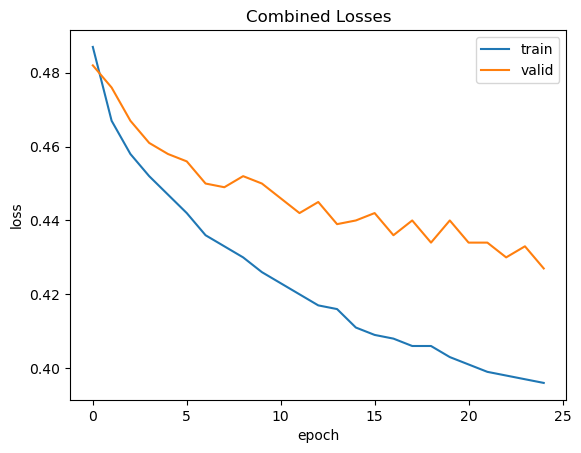

In [23]:
plt.plot(np.arange(0, 25), avg_train_metrics['losses'], label='train')
plt.plot(np.arange(0, 25), avg_valid_metrics['losses'], label='valid')
plt.title('Combined Losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend();

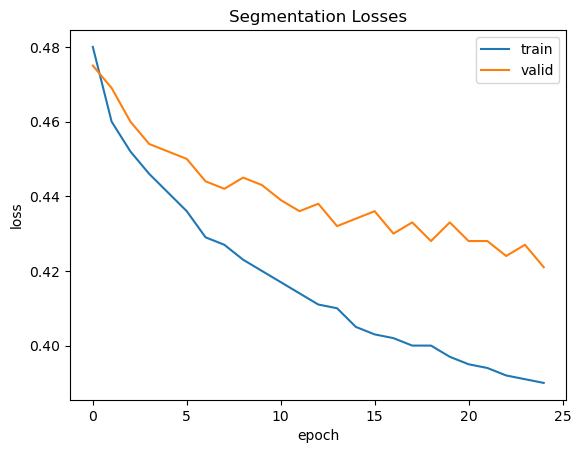

In [24]:
plt.plot(np.arange(0, 25), avg_train_metrics['seg_losses'], label='train')
plt.plot(np.arange(0, 25), avg_valid_metrics['seg_losses'], label='valid')
plt.title('Segmentation Losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend();

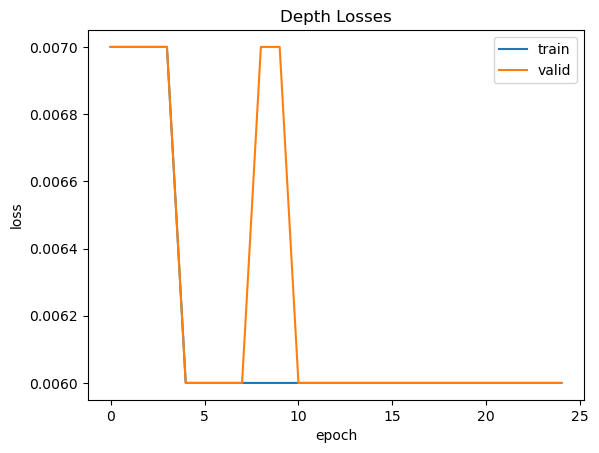

In [25]:
plt.plot(np.arange(0, 25), avg_train_metrics['depth_losses'], label='train')
plt.plot(np.arange(0, 25), avg_valid_metrics['depth_losses'], label='valid')
plt.title('Depth Losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend();

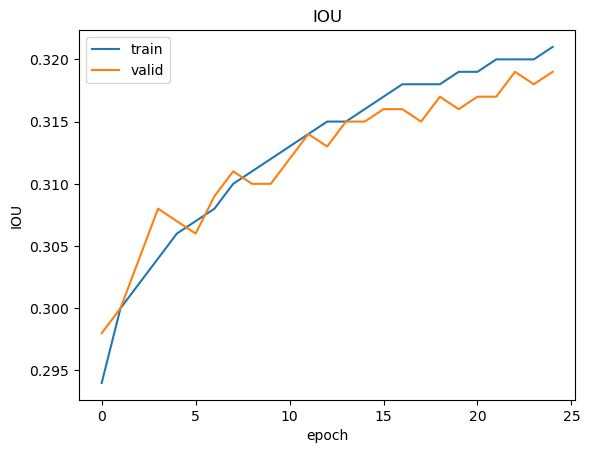

In [27]:
plt.plot(np.arange(0, 25), avg_train_metrics['iou'], label='train')
plt.plot(np.arange(0, 25), avg_valid_metrics['iou'], label='valid')
plt.title('IOU')
plt.xlabel('epoch')
plt.ylabel('IOU')
plt.legend();

## Test Model Inference

In [117]:
sample = valid_dataset[100] # failure mode
sample = valid_dataset[53] # bias depth of lightpole to be concentrated in the front of the image
sample = valid_dataset[48] # good sample
sample = valid_dataset[408] # good sample
sample = valid_dataset[38] # good sample
sample = valid_dataset[108] # can you see the bike? the model can
sample = valid_dataset[189] # missed the tent
sample = valid_dataset[190] # good people example
sample = valid_dataset[201] # good example
# sample = valid_dataset[0]
# sample = test_dataset[1000]

left, mask, depth = sample['left'], sample['mask'], sample['depth']
left, mask, depth = left.to(DEVICE), mask.to(DEVICE), depth.to(DEVICE)

In [118]:
# weights_path = r"C:\Users\itber\Documents\learning\self_tutorials\CV_projects\multitask_depth_seg\models\model_23_ft_half.pth"
weights_path = r"C:\Users\itber\Documents\learning\self_tutorials\CV_projects\multitask_depth_seg\models\model_24_ft_full.pth"
model.load_state_dict(torch.load(weights_path));

In [119]:
model.eval()

with torch.no_grad():
    pred_seg, pred_depth = model(left.unsqueeze(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


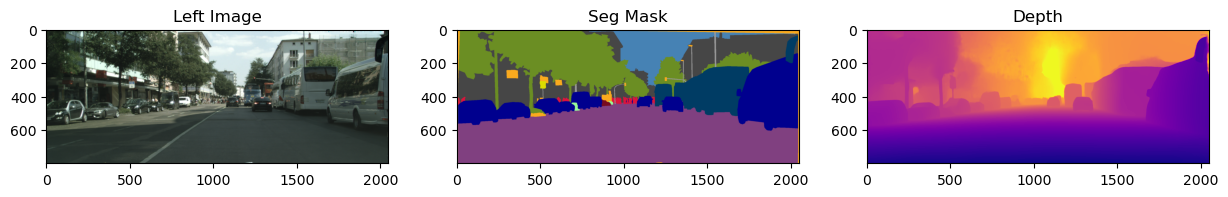

In [120]:
plot_items(left, mask, depth.squeeze(0), labels, NUM_SEG_CLASSES, id_type='trainId')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


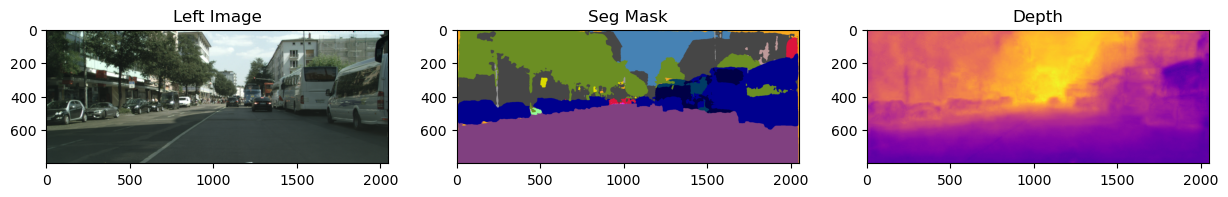

: 

In [121]:
plot_items(left, pred_seg.argmax(dim=1).squeeze(0), pred_depth.squeeze(0), labels=labels, id_type='trainId');